In [2]:
import matplotlib.pyplot as plt
import numpy as np
import enum
import random
import math

$x = r x (1 - x)$, где $x$ - искомое неизвестное, $r > 0$ - параметр. Корни: $x_1 = 0, x_2 = 1 - 1/r$.

In [3]:
eps_r = 1e-10
eps_seq = 1e-12
eps_root = 1e-6

def logistic_map(x, r):
    return r * x * (1 - x)

In [4]:
def first_x(r):
    return random.uniform((r - 1) / (2 * r) + 1e-10, (r + 1) / (2 * r) - 1e-10)

def simple_iterations_method(r):
    iterations_lim = 1e7
    iterations_cur = 0

    x_cur = first_x(r)
    x_next = logistic_map(x_cur, r)

    while abs(x_next - x_cur) > eps_seq:
        iterations_cur += 1
        x_cur = x_next
        x_next = logistic_map(x_cur, r)
        if iterations_cur > iterations_lim:
            return None

    return (x_next, iterations_cur)

$\varphi(x) = r x (1 - x)$

$\varphi'(x) = r (1 - 2x)$

**Достаточное условие сходимости**

$|\varphi'(x)| \leq q < 1$

Выполняется на отрезке $ \frac{r - 1}{2r} < x < \frac{r + 1}{2 r}$, при условии $r > 0$

Для начала посмотрим к какому из корней $x_1$, $x_2$ сходится метод простых итераций на каждом из интервалов $(0;1)$ и $(1;3)$.


In [5]:
def simulate_for_range(left_r, right_r):
    x1_num, x2_num = 0, 0
    unresolved_parameters = []
    bad_accuracy = []

    for _ in range(10**5):
        r = random.uniform(left_r + eps_r, right_r - eps_r)
        x1 = 0.0
        x2 = 1 - (1 / r)
        method_result = simple_iterations_method(r)
        if method_result is not None:
            (result, it) = method_result
            if abs(result - x1) < min(abs(result - x2), eps_root):
                x1_num += 1
            elif abs(result - x2) < eps_root:
                x2_num += 1
            else:
                bad_accuracy.append(r)
        else:
            unresolved_parameters.append(r)
    return (x1_num, x2_num, bad_accuracy, unresolved_parameters)


In [6]:
print(simulate_for_range(0, 1))
print(simulate_for_range(1, 3))


(100000, 0, [], [])
(0, 99997, [], [2.999976953551671, 2.999950481311111, 2.99996749719463])


Покажем теперь численно, что:
* при $0 < r < 1$ итерационная последовательность сходится к $x_1 = 0$ монотонно;
* при $1 < r < 2$ итерационная последовательность сходится к $x_2 = 1 - \frac{1}{r}$ монотонно;
* при $2 < r < 3$ итерационная последовательность сходится к $x_2 = 1 - \frac{1}{r}$ колебательно.


In [7]:
class RootType(enum.Enum):
    FIRST = 1
    SECOND = 2

def detect_side(sequence, root):
    side_same, side_other = 0, 0

    for i in range(len(sequence) - 1):
        fst = sequence[i]
        snd = sequence[i + 1]
        d = (fst - root) * (snd - root)
        if d > 0:
            side_same += 1
        elif d < 0:
            side_other += 1
    return (root, side_same, side_other)

def get_iterative_sequence(r):
    iterations_lim = 1e5
    iterations_cur = 0
    x_cur = first_x(r)
    x_next = logistic_map(x_cur, r)

    sequence = [x_cur, x_next]

    while iterations_cur < iterations_lim:
        iterations_cur += 1
        x_cur = x_next
        x_next = logistic_map(x_cur, r)
        sequence.append(x_next)
    return sequence


def get_sequence_limit(sequence):
    # last n elements should be in eps-neighbourhood
    n = 10**3
    size = len(sequence)
    possible_root = sequence[size - 1]

    for i in range(n):
        if abs(possible_root - sequence[size - 1 - n]) > eps_root:
            return None
    return possible_root

def simple_iterations_method_type_detection(r):
    iterations_lim = 1e7
    iterations_cur = 0
    side_same, side_other = 0, 0
    x_cur = first_x(r)
    x_next = logistic_map(x_cur, r)

    sequence = [x_cur, x_next]

    while abs(x_next - x_cur) > eps_seq:
        iterations_cur += 1
        x_cur = x_next
        x_next = logistic_map(x_cur, r)
        sequence.append(x_next)
        if iterations_cur > iterations_lim:
            return None

    root = x_next

    if not abs(root) < eps_root and not abs(root - (1 - 1 / r)) < eps_root:
        return (root, 0, 0)
    
    return detect_side(sequence, root)

In [8]:
def simulate_for_range_and_root(left_r, right_r, rootType):
    total_side_saved, total_side_changed = 0, 0
    errors = []
    unresolved_parameters = []

    for _ in range(10**4):
        r = random.uniform(left_r + eps_r, right_r - eps_r)
        root = 0 if rootType == RootType.FIRST else (1 - 1 / r)

        method_result = simple_iterations_method_type_detection(r)
        if method_result is not None:
            (res, dir_saved, dir_changed) = method_result
            if abs(res - root) < eps_root:
                total_side_saved += dir_saved
                total_side_changed += dir_changed
            else:
                errors.append((r, res))
        else:
            unresolved_parameters.append(r)
    return (total_side_saved,  total_side_changed, errors, unresolved_parameters)


In [9]:
print(simulate_for_range_and_root(0, 1, RootType.FIRST))
print(simulate_for_range_and_root(1, 2, RootType.SECOND))
print(simulate_for_range_and_root(2, 3, RootType.SECOND))

(2533256, 2517, [], [])
(1507965, 2604, [], [])
(3351, 1943333, [], [2.9999802100854858, 2.9999648185398557])


При $0 < r < 1$ сходимость к корню $x_1 = 0$. Получим следующее: $\varphi'(x_1) = r \Rightarrow 0 < \varphi'(x) \le r < 1$. Таким образом, сходимость монотонная.

При $1 < r < 2$ сходимость к корню $x_2 = 1 - \frac{1}{r}$. Получим следующее:
$\varphi'(x_2) = 2 - r \Rightarrow 0 < \varphi'(x) \leq 2 - r < 1$. Таким образом, сходимость монотонная.

При $2 < r < 3$ сходимость к корню $x_2 = 1 - \frac{1}{r}$. Получим следующее:
$\varphi'(x_2) = 2 - r \Rightarrow -1 < 2 - r \leq \varphi'(x) < 0$. Таким образом, сходимость колебательная.

In [10]:
def show_graph_for_r_in_range(left_r, right_r):
    r = random.uniform(left_r + eps_r, right_r - eps_r)
    print(r)
    i_coords = []
    x_coords = []

    x_cur = first_x(r)

    x_coords.append(x_cur)
    i_coords.append(0)

    for i in range(1,50):
        x_cur = logistic_map(x_cur, r)
        i_coords.append(i)
        x_coords.append(x_cur)

    plt.plot(i_coords, x_coords)
    plt.show()

Продемонстрируем графиком, что сходимость при $0 < r < 1$ монотонная. 

0.5270328982674691


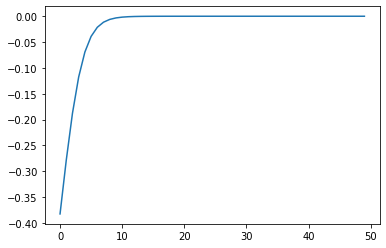

In [11]:
show_graph_for_r_in_range(0, 1)

Продемонстрируем графиком, что сходимость при $1 < r < 2$ монотонная. 

1.77673051404122


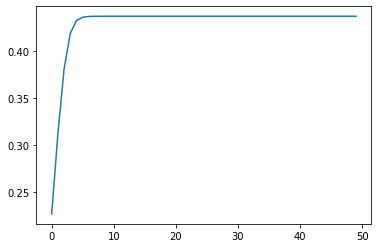

In [12]:
show_graph_for_r_in_range(1, 2)

Продемонстрируем графиком, что сходимость при $2 < r < 3$ колебательная. 

2.5589674696432465


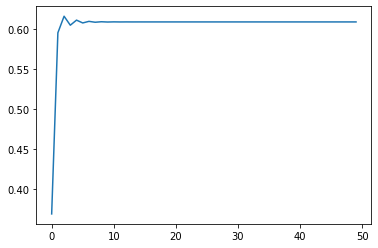

In [13]:
show_graph_for_r_in_range(2, 3)

Рассмотрим $r > 3$. В окрестности корня $x_1 = 0$ (например, $[-0.25; 0.25]$) $|\varphi'(x)| > 1$, что выполняется также и в окрестности корня $x_2 = 1 - \frac{1}{r}$.
Покажем расходимость итерационной последовательности в этом случае.

In [14]:
def simple_iterations_method_divergence_detection(r):
    sequence = get_iterative_sequence(r)
    root = get_sequence_limit(sequence)

    return root is None or abs(root) == np.inf

def simulate_for_range_and_root_divergence(left_r, right_r):
    total_side_saved, total_side_changed = 0, 0
    divergence_cnt = 0
    convergence_cnt = 0

    for _ in range(10**4):
        r = random.uniform(left_r + eps_r, right_r - eps_r)
        is_divergent = simple_iterations_method_divergence_detection(r)

        if is_divergent:
            divergence_cnt += 1
        else:
            convergence_cnt += 1
    return (divergence_cnt, convergence_cnt)

In [15]:
# TODO
# print(simulate_for_range_and_root_divergence(3, 100000))

Покажем, что в диапазонах $3 < r < r_1$, $r_1 < r < r_2$, ..., где $r_n = r_{\infty} - \frac{1}{\delta^n}$, итерационная последовательность распадается на $2$, $4$, ..., $2^n$,... подпоследовательностей, каждая из которых имеет свой предел.
Для этого изобразим на графике диапазоны различными цветами, пределами будут точки сгущения последовательности.

In [16]:
FEIGENBAUM_R_INF = 3.5699456
FEIGENBAUM_DELTA = 4.66920116

def feigenbaum_const(n):
    return FEIGENBAUM_R_INF - 1 / (FEIGENBAUM_DELTA ** n)

def get_consts():
    cur_const = 3
    ind = 1
    next_const = feigenbaum_const(ind)
    consts = []

    while abs(cur_const - next_const) > eps_seq:
        cur_const = next_const
        ind += 1
        next_const = feigenbaum_const(ind)
        consts.append(cur_const)
    return consts

def show_bifurcation():
    left = 3
    it_step = 1e-3

    colors = ['b.', 'g.', 'r.', 'c.', 'k.', 'm.']
    consts = get_consts()
    c = 0
    for r in np.arange(left + eps_r, FEIGENBAUM_R_INF, it_step):
        sequence = get_iterative_sequence(r)
        if consts[c] < r:
            c += 1
        color = colors[c % len(colors)]
        plt.plot([r] * len(sequence), sequence, color, ms=0.01)
    plt.show()

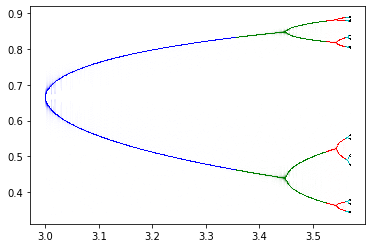

In [17]:
show_bifurcation()

Покажем, что в диапазоне $r_{\infty} < r < 4$ поведение итерационной последовательности становится похожим на хаос и существенно меняется при различных $r$.

In [18]:
def show_chaos():
    right = 4
    it_step = 1e-2
    
    for r in np.arange(FEIGENBAUM_R_INF + eps_r, right, it_step):
        sequence = get_iterative_sequence(r)
        plt.plot([r] * len(sequence), sequence, "r.", ms=0.01)
    plt.show()

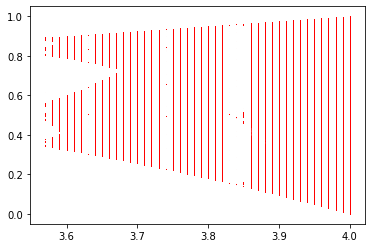

In [19]:
show_chaos()

Продемонстрируем графиком, что в зависимости от выбранного $r$ на интервале $3 < r < r_{\infty}$ итерационная последовательность будет иметь $2$, $4$, $8$ ... $2^n$ пределов.

1) r = 3.177888101168991 in (3, 3.355776202337981)


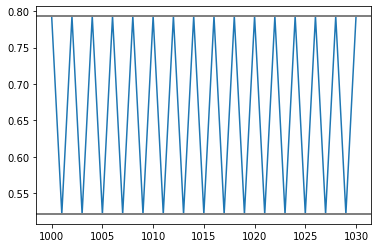

2) r = 3.439926635721535 in (3.355776202337981, 3.524077069105088)


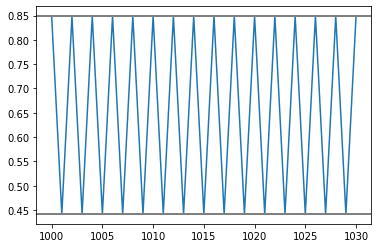

3) r = 3.5420995167358416 in (3.524077069105088, 3.560121964366595)


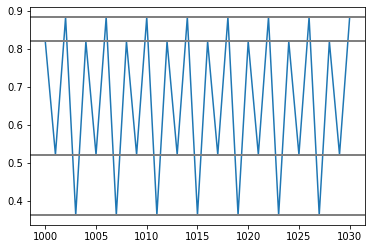

4) r = 3.563981821120069 in (3.560121964366595, 3.5678416778735427)


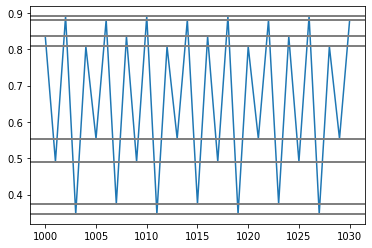

In [38]:
def get_coords_for_feigenbaum(r): 
    x_cur = first_x(r)
    for i in range(1, 1000):
        x_cur = logistic_map(x_cur, r)
    
    i_coords = [1000]
    x_coords = [x_cur]

    for i in range(1001, 1031):
        x_cur = logistic_map(x_cur, r)
        i_coords.append(i)
        x_coords.append(x_cur)  
    return i_coords, x_coords

def plot_doubling_period_graphs():
    borders = [3] + [feigenbaum_const(i) for i in range(1, 5)]
    for i in range(len(borders) - 1):
        left_r, right_r = borders[i], borders[i + 1]
        r = (left_r + right_r) / 2
        print("{}) r = {} in ({}, {})".format(i + 1, r, left_r, right_r))
        i_coords, x_coords = get_coords_for_feigenbaum(r)
        plt.plot(i_coords, x_coords)
        for xc in x_coords:
            plt.axhline(xc, color='gray')
        plt.show()
        
plot_doubling_period_graphs()

Продемонстрируем графиком, что на интервале $r_{\infty} < r < 4$ поведение итерационной последовательности похоже на случайное (детерминированный хаос).

3.974730277883227


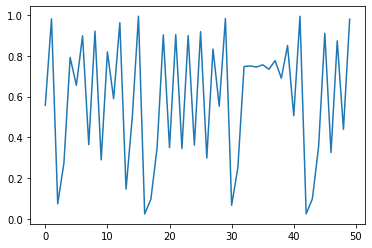

In [21]:
show_graph_for_r_in_range(FEIGENBAUM_R_INF, 4)

In [22]:
# нужны еще графики x_i -> phi(x_i) (если судить по заданию). 